## 1. Data preparation
Import packages

In [1]:
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import urllib.request  as urllib2
import pandas as pd
import json
import numpy as np
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import lxml
import requests

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 1.1. Read data about crime rate of cities

In [3]:
#Read the page
url_wiki = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_crime_rate"
critme_raw_df = pd.read_html(url_wiki, header=1)[0].copy()
critme_raw_df.head()

,State,City,Population,Total,Murder and Nonnegligent Manslaughter,Rape1,Robbery,Aggravated Assault,Total.1,Burglary,Larceny-Theft,Motor Vehicle Theft,Arson2
0,Alabama,Mobile3,248431,740.25,20.13,57.16,177.11,485.85,5453.83,1216.84,3730.21,506.78,22.94
1,Alaska,Anchorage,296188,1203.29,9.12,132.01,262.67,799.49,5415.82,748.17,3619.66,1047.98,20.93
2,Arizona,Chandler,249355,259.47,2.01,52.13,56.95,148.38,2329.61,314.41,1866.01,149.18,NaN
3,Arizona,Gilbert,242090,85.51,2.07,16.11,21.07,46.26,1385.85,192.49,1137.59,55.76,12.39
4,Arizona,Glendale,249273,488.22,4.81,38.91,192.96,251.53,4530.37,637.45,3426.36,466.56,19.26


In [4]:
print(critme_raw_df.count())

State                                   100
City                                    100
Population                              100
Total                                    96
Murder and Nonnegligent Manslaughter    100
Rape1                                    96
Robbery                                 100
Aggravated Assault                      100
Total.1                                 100
Burglary                                100
Larceny-Theft                           100
Motor Vehicle Theft                     100
Arson2                                   92
dtype: int64


#### Data cleaning
We will consider cities with a population of less than 500 thousand

In [5]:
critme_df = critme_raw_df
critme_df = critme_df[critme_df.Population < 220000]
critme_df = critme_df[['State', 'City', 'Population', 'Total', 'Total.1', 'Arson2']]
print(critme_df.count())
critme_df.head()

State         4
City          4
Population    4
Total         4
Total.1       4
Arson2        4
dtype: int64


,State,City,Population,Total,Total.1,Arson2
20,California,San Bernardino,217259,1291.09,3867.73,30.84
25,California,Santa Clarita,216350,162.70,1424.08,6.01
44,Iowa,Des Moines,217277,670.11,4413.26,19.33
97,Washington,Spokane,217066,626.54,7231.44,23.03


Drop NaN

In [6]:
critme_df = critme_df.dropna()
critme_df.head()

,State,City,Population,Total,Total.1,Arson2
20,California,San Bernardino,217259,1291.09,3867.73,30.84
25,California,Santa Clarita,216350,162.70,1424.08,6.01
44,Iowa,Des Moines,217277,670.11,4413.26,19.33
97,Washington,Spokane,217066,626.54,7231.44,23.03


Sum categories of crime

In [7]:
critme_df['Crime_Rate'] = critme_df['Total'] + critme_df['Total.1'] + critme_df['Arson2']
critme_df_result = critme_df[['State', 'City', 'Population', 'Crime_Rate']]
critme_df_result.head()
print(critme_df_result.count())

State         4
City          4
Population    4
Crime_Rate    4
dtype: int64


### 1.2 Create data abouf sport venues
#### Set geolocator, parametes to Foursquare API

In [8]:
geolocator = Nominatim(user_agent = 'test')
CLIENT_ID = '1ROEGGL32JNNXXQVZ1XAQM1RN11GXZVG0OPQYTXUES1NZWKJ'
CLIENT_SECRET = 'CV12M1JW2IX22BY2PDG1PPNPFBGRJIWIGOLYX5PFVXF4S1BE' 
VERSION = '20180604'
LIMIT = 2000

#### Count sport venues

In [9]:
def count_venues(lat, lng, category_id_list, radius=10000):
        
    counter_list = []
    
    total_count = 0
    
    for category_id in category_id_list:
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category_id
        )
        
        count = 0
        # make the GET request
        try:
            result_get = requests.get(url).json()
            count = len(result_get["response"]['groups'][0]['items'])
        except:
            # retry one more time
            try:
                result_get = requests.get(url).json()
                count = len(result_get["response"]['groups'][0]['items'])
            except:
                print(result_get)
                return []
            
        counter_list.append(count)
        total_count += count
    #print(counter_list)
    
    counter_list.append(total_count)
    return counter_list

#### Define categories of sport venues using Foursquare list of venue categories:
https://developer.foursquare.com/docs/resources/categories

In [10]:
categories = {'athletics stadium': '4bf58dd8d48988d187941735',
              'badminton court': '52e81612bcbc57f1066b7a2b',
              'baseball field': '4bf58dd8d48988d1e8941735',
              'basketball court': '4bf58dd8d48988d1e1941735',
              'football field': '4cce455aebf7b749d5e191f5',
              'gym / fitness':  '4bf58dd8d48988d175941735',
              'hockey field': '56aa371be4b08b9a8d57352c',
              'rink': '4bf58dd8d48988d168941735',
              'ski tracking': '4eb1c0f63b7b52c0e1adc2eb',
              'sport club': '52e81612bcbc57f1066b7a2e',
              'swimming school': '52e81612bcbc57f1066b7a44',
              'tennis court': '4e39a956bd410d7aed40cbc3',
              'volleyball court': '4eb1bf013b7b6f98df247e07'
             }

#### Get numbers of sport venues for each city

In [11]:
draft_data_list = []
for state, c, p, cr in zip(critme_df_result['State'], critme_df_result['City'], critme_df_result['Population'], critme_df_result['Crime_Rate']):
    city = ''.join([i for i in c if not i.isdigit()])
    location = geolocator.geocode(state + ' ' + city)
    city_data = [p]
    if (location):
        print((city, location.latitude, location.longitude))
        venues_count_list = count_venues(location.latitude, location.longitude, categories.values())
        if len(venues_count_list) > 0:
            city_data.extend(venues_count_list)
            city_data.append(cr)
            draft_data_list.append(city_data)
    else:
        print(city + ' cannot get location')

('San Bernardino', 34.1083449, -117.2897652)
('Santa Clarita', 34.3916641, -118.542586)
('Des Moines', 41.5910641, -93.6037149)
('Spokane', 47.6579425, -117.4212265)


In [12]:
draft_data_list

[[217259, 9, 0, 10, 1, 5, 4, 0, 5, 0, 1, 66, 1, 3, 105, 5189.66],
 [216350, 5, 0, 4, 3, 10, 6, 0, 5, 1, 4, 100, 1, 10, 149, 1592.79],
 [217277, 24, 3, 12, 1, 3, 3, 0, 10, 0, 2, 100, 5, 24, 187, 5102.7],
 [217066, 6, 0, 13, 3, 4, 1, 0, 9, 0, 1, 90, 2, 21, 150, 7881.009999999999]]

In [13]:
c = ['Population']
c.extend(categories.keys())
c.extend(['total_sports','Crime_Rate'])
df_final = pd.DataFrame(draft_data_list, columns = c)
df_final.iloc[:, 1:len(categories.keys()) + 2] = df_final.iloc[:, 1:len(categories.keys()) + 2].div(0.001 * df_final.Population, axis = 0)
df_final.head()

,Population,baseball field,hockey field,basketball court,sport club,tennis court,athletics stadium,badminton court,football field,swimming school,volleyball court,gym / fitness,rink,ski tracking,total_sports,Crime_Rate
0,217259,0.041425,0.000000,0.046028,0.004603,0.023014,0.018411,0.0,0.023014,0.000000,0.004603,0.303785,0.004603,0.013808,0.483294,5189.66
1,216350,0.023111,0.000000,0.018489,0.013866,0.046221,0.027733,0.0,0.023111,0.004622,0.018489,0.462214,0.004622,0.046221,0.688699,1592.79
2,217277,0.110458,0.013807,0.055229,0.004602,0.013807,0.013807,0.0,0.046024,0.000000,0.009205,0.460242,0.023012,0.110458,0.860653,5102.70
3,217066,0.027641,0.000000,0.059890,0.013821,0.018428,0.004607,0.0,0.041462,0.000000,0.004607,0.414620,0.009214,0.096745,0.691034,7881.01


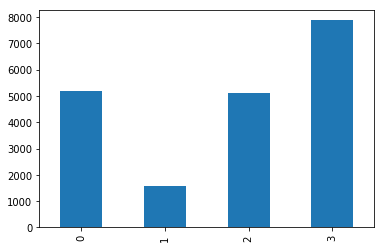

In [17]:
%matplotlib inline  
df_final['Crime_Rate'].plot(kind = 'bar')

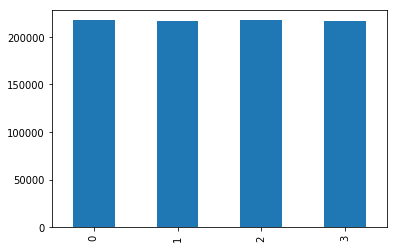

In [18]:
df_final['Population'].plot(kind = 'bar')

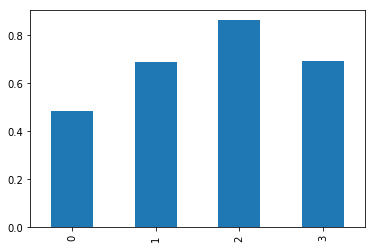

In [19]:
df_final['total_sports'].plot(kind = 'bar')

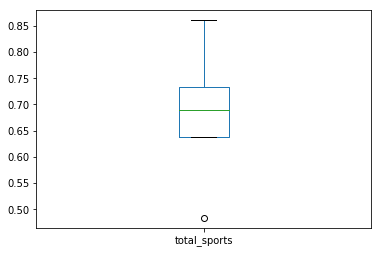

In [23]:
df_final['total_sports'].plot.box()

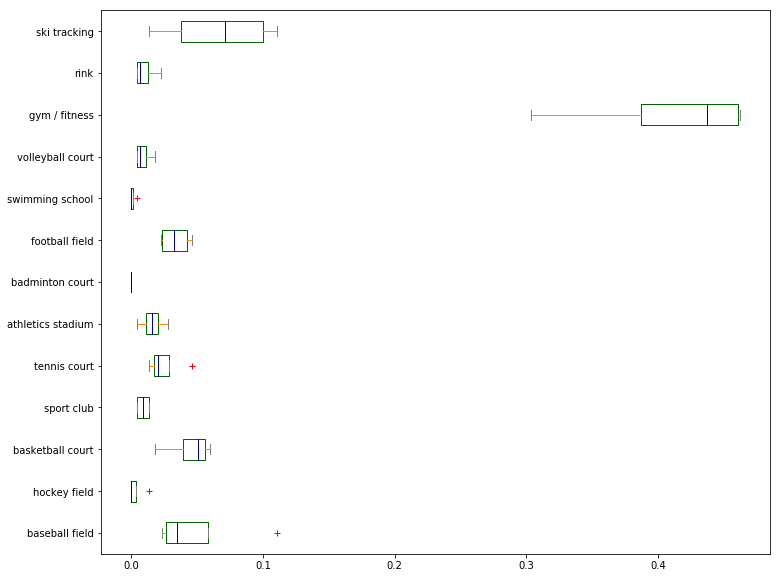

In [42]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
df_final.iloc[:, 1:-2].plot.box(color=color, sym='r+', vert=False, figsize=(12, 10))

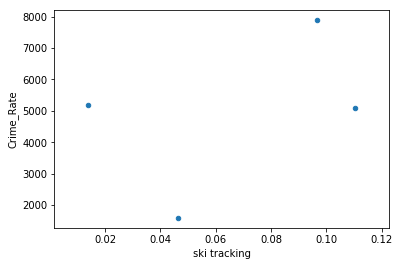

In [44]:
df_final.plot.scatter(x='ski tracking', y='Crime_Rate');